In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)

from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ID = "02"
MODEL_NAME = "LSTM"
NUM_FEATURES = "12"
TARGET_NAME = "Pct_Range_Close_diff"
FRECUENCIA = "1D"
MSE_RESULT = 0

In [4]:
RANGE = 2

HYPER_L1_IN = RANGE
EPOCHS = 5
BATCH_SIZE = 1

TEST_SIZE = .20
VAL_SIZE = .1

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [5]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_1M_20F.csv
EURUSD_FULL_4H_20F.csv


In [6]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,5.597896e+05,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,1.277971e+06,0.00026,Friday,4,0.000787,0.000787,0.000000,0.0,0.0,0.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,8.372040e+04,0.00010,Sunday,6,0.003862,0.003075,0.000000,0.0,0.0,0.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,1.353480e+06,0.00010,Monday,0,0.004053,0.000191,0.000000,0.0,0.0,0.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,1.354807e+06,0.00010,Tuesday,1,0.002523,-0.001530,1.263726,0.0,0.0,0.0


In [7]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 20)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05   
std       0.122817     0.123571     0.121969     0.122813  5.305200e+05   
min  

In [8]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 18)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  Spread  weekday  Pct_Range_Close  \
0  1.22791    1.23169  1291823.750  0.0001        4        -0.003680   
1  1.22955    1.23099    93508.000  0.0001        6        -0.000568   
2  1.21298    1.21486  1348137.000  0.0001        0        -0.013102   
3  1.20583    1.20701  1344214.000  0.0001        1        -0.006461   
4  1.20504    1.20784  1355827.375  0.0001        2         0.000688   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.005690    

In [9]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [10]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(4938, 18)


In [11]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  4938


In [12]:
#generate the VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


index column:  13
VECTOR Y: Pct_Range_Close_diff
1    0.003112
2   -0.012534
3    0.006641
4    0.007149
5    0.001672
Name: Pct_Range_Close_diff, dtype: float64
(4937,)
4933   -0.003565
4934    0.002085
4935   -0.002955
4936    0.000000
4937    0.000000
Name: Pct_Range_Close_diff, dtype: float64
(4938,)


In [13]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 1481
end of train:  3457
count val:  493
count test:  987
end_val 3950


In [14]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3457, 18)
data_val.shape:  (493, 18)
data_test.shape:  (988, 18)
data_training_y.shape:  (3457,)
data_val_y.shape:  (493,)
data_test_y.shape:  (988,)


In [15]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.34423101 0.33894661 0.33438201 ... 0.28177762 0.29589212 0.27537111]
 [0.33519908 0.32853916 0.33743607 ... 0.28352083 0.2964743  0.27506306]
 [0.33487197 0.32696721 0.30695073 ... 0.28387155 0.29635107 0.27455402]
 ...
 [0.14981736 0.14364441 0.13776355 ... 0.07989539 0.05620358 0.00150176]
 [0.13471569 0.13330924 0.11496854 ... 0.08165535 0.05667972 0.00073492]
 [0.1186145  0.12371488 0.11541009 ... 0.08353327 0.05703509 0.        ]]


(3457, 18)


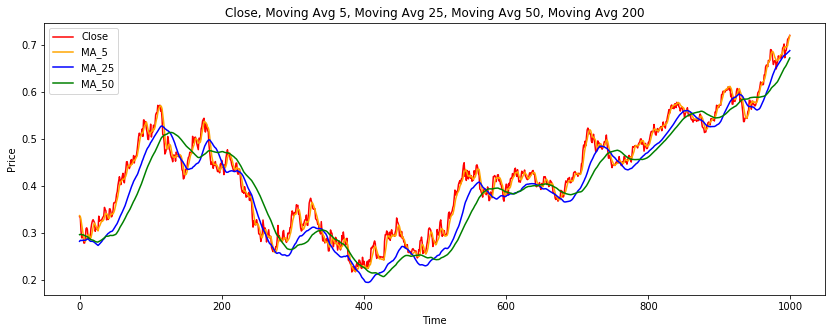

In [16]:
INICIO = 0
FIN = 1000
print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,14], color = 'orange', label = 'MA_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,15], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,16], color = 'green', label = 'MA_50')
#pyplot.plot(data_training_array_scaled[INICIO:FIN,11], color = 'gray', label = 'MA_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3457, 18)


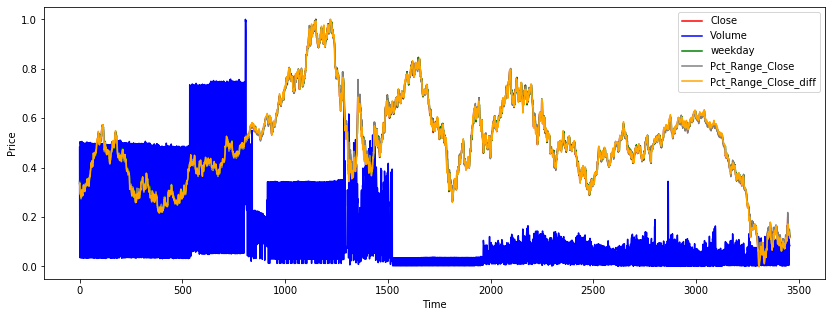

In [17]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,4], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,5], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,6], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3457, 18)


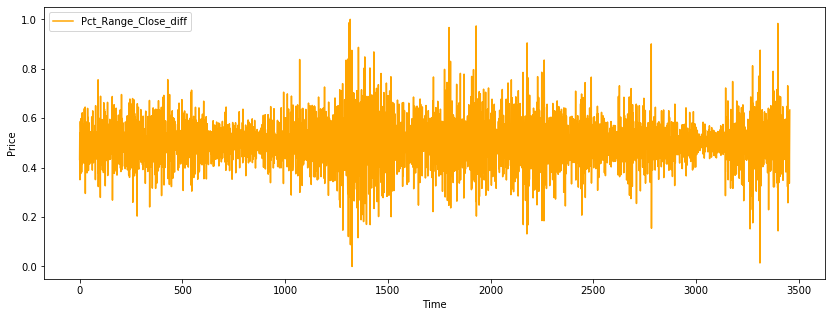

In [18]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(14,5))

pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

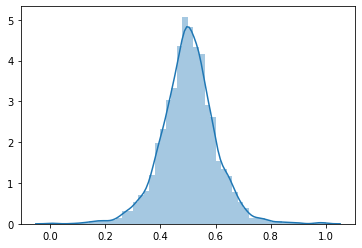

In [19]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);

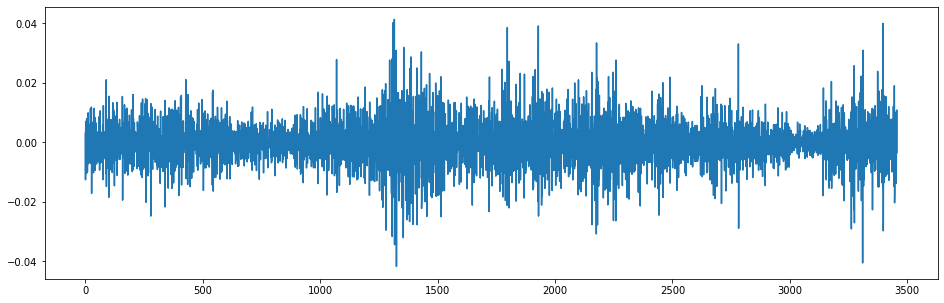

In [20]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [21]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(3455, 2, 18)
(3455,)


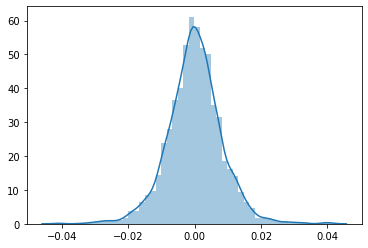

In [22]:
sns.distplot(y_train_np);



In [23]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(2, 18)
(493, 18)
<bound method NDFrame.head of         Open     High      Low    Close       Volume  Open_Bid  High_Bid  \
0    1.12126  1.12436  1.10875  1.11242  192481.8594   1.12122   1.12434   
1    1.11240  1.11905  1.10899  1.11582  189329.3438   1.11239   1.11895   
2    1.11651  1.11653  1.11430  1.11548    6353.3198   1.11627   1.11628   
3    1.11546  1.11780  1.11219  1.11599  137144.1094   1.11539   1.11778   
4    1.11599  1.12298  1.11527  1.12070  198090.9844   1.11594   1.12296   
..       ...      ...      ...      ...          ...       ...       ...   
490  1.08167  1.08269  1.07403  1.07588  173213.3750   1.08162   1.08264   
491  1.07588  1.07683  1.06724  1.06879  166713.5000   1.07582   1.07679   
492  1.06881  1.07020  1.06522  1.06561  185265.9219   1.06875   1.07018   
493  1.06666  1.06741  1.06590  1.06697    8386.2197   1.06594   1.06737   
494  1.06697  1.06813  1.06426  1.06701  170208.7656   1.06692   1.06809   

     Low_Bid  Close_Bid   Volume_Bid   

In [24]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(2,)
(493,)
0    0.010914
1   -0.003361
2    0.000762
3    0.003763
4   -0.003185
5    0.004705
6   -0.000839
7   -0.004540
8   -0.003368
9   -0.000336
Name: Pct_Range_Close_diff, dtype: float64


In [25]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[ 1.34715685e-01  1.33309242e-01  1.14968540e-01  1.16602303e-01
   8.53305162e-02  1.34880678e-01  1.33369477e-01  1.15019326e-01
   1.16664237e-01  6.46111434e-02  8.33333333e-03  5.00000000e-01
   3.09290466e-01  4.96079586e-01  1.24838778e-01  8.16553455e-02
   5.66797227e-02  7.34915593e-04]
 [ 1.18614498e-01  1.23714879e-01  1.15410089e-01  1.22795832e-01
   8.39204777e-02  1.18831676e-01  1.23628806e-01  1.15479477e-01
   1.21383281e-01  6.07108315e-02  6.83333333e-01  6.66666667e-01
   4.85394797e-01  6.33169765e-01  1.22853650e-01  8.35332678e-02
   5.70350892e-02  0.00000000e+00]
 [ 1.26083559e-01  1.19161623e-01  1.25179380e-01  1.22176479e-01
   2.08004799e-03  1.25883786e-01  1.18803650e-01  1.25105835e-01
   1.22130311e-01  1.46085708e-03  5.83333333e-02  1.00000000e+00
   4.31160392e-01  4.61325266e-01  1.20251674e-01  8.49998964e-02
   5.74199330e-02 -5.65744128e-04]
 [ 1.24175405e-01  1.21456319e-01  1.21297421e-01  1.23105509e-01
   6.05793759e-02  1.24284338e-01  1.

In [26]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(493, 2, 18)
(493,)


In [27]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(2, 18)
(988, 18)


(990, 18)

In [28]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(2,)
(988,)


(990,)

In [29]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[ 1.34715685e-01  1.33309242e-01  1.14968540e-01  1.16602303e-01
   8.53305162e-02  1.34880678e-01  1.33369477e-01  1.15019326e-01
   1.16664237e-01  6.46111434e-02  8.33333333e-03  5.00000000e-01
   3.09290466e-01  4.96079586e-01  1.24838778e-01  8.16553455e-02
   5.66797227e-02  7.34915593e-04]
 [ 1.18614498e-01  1.23714879e-01  1.15410089e-01  1.22795832e-01
   8.39204777e-02  1.18831676e-01  1.23628806e-01  1.15479477e-01
   1.21383281e-01  6.07108315e-02  6.83333333e-01  6.66666667e-01
   4.85394797e-01  6.33169765e-01  1.22853650e-01  8.35332678e-02
   5.70350892e-02  0.00000000e+00]
 [ 3.61277191e-02  3.25051947e-02  3.18835780e-02  3.53577674e-02
   7.54642024e-02  3.62420255e-02  3.24749255e-02  3.18608504e-02
   3.53837184e-02  6.11325715e-02  1.66666667e-02  1.66666667e-01
   4.48326365e-01  5.10474163e-01  2.36794784e-02 -1.19442554e-02
  -2.88894921e-02 -6.37694243e-02]
 [ 3.76178967e-02  3.31737284e-02  3.19019759e-02  3.42283591e-02
   8.58719135e-02  3.77687708e-02  3.

In [30]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(988, 2, 18)
(988,)


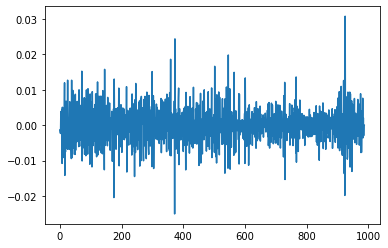

In [31]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

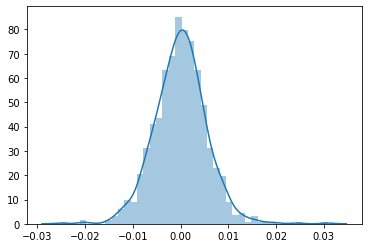

In [32]:
sns.distplot(y_test_np);


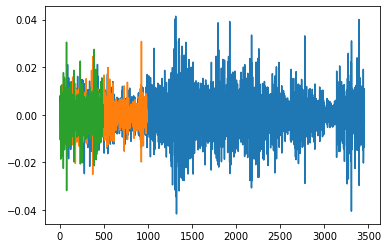

In [33]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [34]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

2
18


In [35]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 20, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 8, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


In [36]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [37]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [38]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 2)              168       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 352       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [39]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/


In [40]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [41]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





Epoch 1/5
3455/3455 [==============================] - 8s 2ms/step - loss: 7.5055e-05 - mean_squared_error: 7.5055e-05 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 2607.9014 - cosine_proximity: -0.0221 - val_loss: 4.9368e-05 - val_mean_squared_error: 4.9368e-05 - val_mean_absolute_error: 0.0053 - val_mean_absolute_percentage_error: 133.7848 - val_cosine_proximity: 0.0385
Epoch 2/5
3455/3455 [==============================] - 7s 2ms/step - loss: 7.2318e-05 - mean_squared_error: 7.2318e-05 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 1069.9294 - cosine_proximity: -0.0016 - val_loss: 6.1595e-05 - val_mean_squared_error: 6.1595e-05 - val_mean_absolute_error: 0.0062 - val_mean_absolute_percentage_error: 449.4808 - val_cosine_proximity: -0.0385te_error: 0.0064 - mean_ab
Epoch 3/5
3455/3455 [==============================] - 7s 2ms/step - loss: 7.1903e-05 - mean_squared_error: 7.1903e-05 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 2359

In [42]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + NUM_FEATURES + '_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)
regressior.save(source_data + file_name)


LSTM_1D_12_Pct_Range_Close_diff_02.hdf5


In [43]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


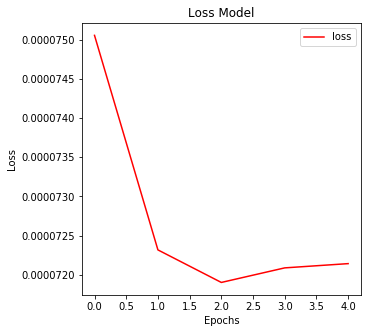

In [44]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

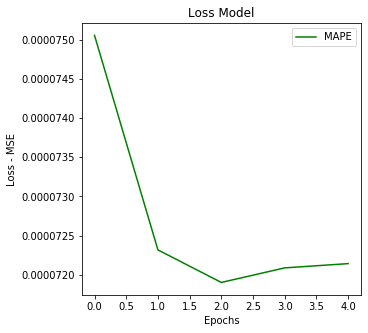

In [45]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [46]:
#Load Model
filepath = os.path.join(source_data, file_name)
#filepath = os.path.join(source_data, r'final_model.hdf5')
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/LSTM_1D_12_Pct_Range_Close_diff_02.hdf5


In [47]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(988, 1)

In [48]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(3455, 1)

(988,)
(988, 1)


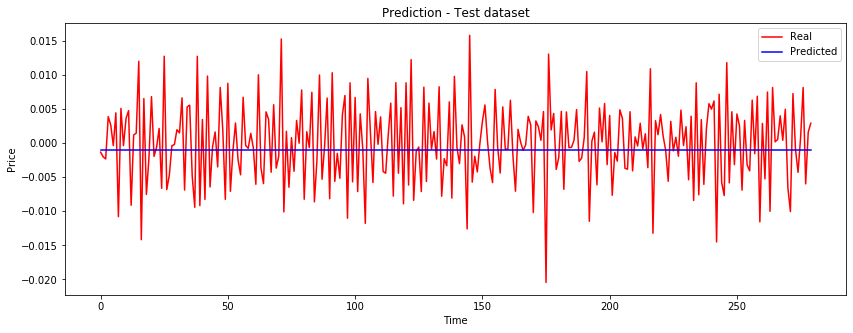

In [49]:
INICIO = 0
FIN = 280
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.004242504222611125
Test RMSE: 0.005550154879699599
Test MSE: 3.080421918865326e-05
Test MAPE: inf


(3455,)


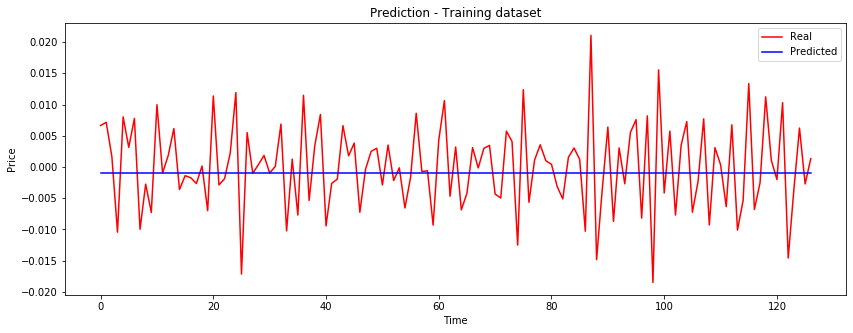

In [52]:
print(y_train_np.shape)
INICIO = 0
FIN = 127
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [53]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.006198212440340066
Train RMSE: 0.008298248092502951
Train MSE: 6.886092140472886e-05
Test MAPE: 31859.831807739403
